# Methylation analysis in Fig 5C-5F

In [1]:
from collections import defaultdict
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
from scipy.stats import fisher_exact

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
def odds_ratio_ci(a, b, c, d):
    """Compute the 95% confidence interval of an odds ratio"""
    
    odds_ratio = (a*d) / (b*c)

    lower_bound = math.exp(math.log(odds_ratio) - 1.96 * math.sqrt((1/a + 1/b + 1/c + 1/d)))
    upper_bound = math.exp(math.log(odds_ratio) + 1.96 * math.sqrt((1/a + 1/b + 1/c + 1/d)))

    return (lower_bound, upper_bound)

In [4]:
colors_d = {
    'methylated': '#1e79baff', 
    'unmethylated': '#cfcac5ff'
}

In [5]:
tissue_d = {
    'COADREAD': 'colon', 
    'ESOPHA_STOMACH': 'esophagus and stomach',
    'NSCLC': 'lung' 
}

In [6]:
data_dir = '../../../data/methylation'

### Load data

- Tables containing SBS1 total mutations in a cancer type and tissue-matched CpG methylation overlap.
- Tables containing SBS1 hotspot mutations in a cancer type and tissue-matched CpG methylation overlap.


In [7]:
ctypes_to_run = ['COADREAD', 'ESOPHA_STOMACH', 'NSCLC']

In [8]:
# Load mutation data
mutations_dict = dict()
for ctype in ctypes_to_run: 
    input_f = f'{data_dir}/{ctype}_counts_methyl_muts.txt.gz'
    mutations_dict[ctype] = pd.read_csv(input_f, sep='\t', header=0)

In [9]:
mutations_dict['COADREAD'].head()

,SIGNATURE,EPIGENOMES,FRAC_METHYLATION,CHR,BINID,TRINUC,TYPE,COUNT
0,SBS1,E084;E106,0.5,chr21,chr21:14000000-15000000,ACG,ME_POS_MUT_POS,86
1,SBS1,E084;E106,0.5,chr21,chr21:14000000-15000000,ACG,ME_POS_MUT_NEG,3005
2,SBS1,E084;E106,0.5,chr21,chr21:14000000-15000000,ACG,ME_NEG_MUT_POS,3
3,SBS1,E084;E106,0.5,chr21,chr21:14000000-15000000,ACG,ME_NEG_MUT_NEG,216
4,SBS1,E084;E106,0.5,chr21,chr21:14000000-15000000,ACG,MISSING,132


In [10]:
# Load hotspots data
hotspots_dict = dict()
for ctype in ctypes_to_run: 
    input_f = f'{data_dir}/{ctype}_counts_methyl_hotspots.txt.gz'
    hotspots_dict[ctype] = pd.read_csv(input_f, sep='\t', header=0)

In [11]:
hotspots_dict['COADREAD'].head()

,SIGNATURE,EPIGENOMES,FRAC_METHYLATION,CHR,BINID,TRINUC,TYPE,COUNT
0,SBS1,E084;E106,0.5,chr19,chr19:12000000-13000000,ACG,ME_POS_MUT_POS,0
1,SBS1,E084;E106,0.5,chr19,chr19:12000000-13000000,ACG,ME_POS_MUT_NEG,4072
2,SBS1,E084;E106,0.5,chr19,chr19:12000000-13000000,ACG,ME_NEG_MUT_POS,0
3,SBS1,E084;E106,0.5,chr19,chr19:12000000-13000000,ACG,ME_NEG_MUT_NEG,991
4,SBS1,E084;E106,0.5,chr19,chr19:12000000-13000000,ACG,MISSING,1097


### Compute stats

In [12]:
mutations_or = dict()
mutations_data = defaultdict(dict)
for ctype in ctypes_to_run: 
    df = mutations_dict[ctype]
    me_pos_mut_pos = df.loc[df['TYPE'] == 'ME_POS_MUT_POS']['COUNT'].sum()
    me_pos_mut_neg = df.loc[df['TYPE'] == 'ME_POS_MUT_NEG']['COUNT'].sum()
    me_neg_mut_pos = df.loc[df['TYPE'] == 'ME_NEG_MUT_POS']['COUNT'].sum()
    me_neg_mut_neg = df.loc[df['TYPE'] == 'ME_NEG_MUT_NEG']['COUNT'].sum()
    total = me_pos_mut_pos + me_pos_mut_neg + me_neg_mut_pos + me_neg_mut_neg
    
    # Mutated CpG
    mut_mepos = me_pos_mut_pos / (me_pos_mut_pos + me_pos_mut_neg)
    mut_meneg = me_neg_mut_pos / (me_neg_mut_pos + me_neg_mut_neg)
    mutations_data[ctype]['mut_mepos'] = (me_pos_mut_pos, mut_mepos)
    mutations_data[ctype]['mut_meneg'] = (me_neg_mut_pos, mut_meneg)
    
    # Methylation
    mutations_data[ctype]['methylated'] = ( me_pos_mut_pos + me_pos_mut_neg, (me_pos_mut_pos + me_pos_mut_neg) / total) 
    mutations_data[ctype]['unmethylated'] = ( me_neg_mut_pos + me_neg_mut_neg, (me_neg_mut_pos + me_neg_mut_neg) / total) 

    # OR
    mutations_data[ctype]['pvalue'] = fisher_exact([[me_pos_mut_pos, me_neg_mut_pos], [me_pos_mut_neg, me_neg_mut_neg]], alternative='two-sided')[0]
    mutations_data[ctype]['odds_ratio'] = (me_pos_mut_pos * me_neg_mut_neg) / (me_pos_mut_neg * me_neg_mut_pos)
    mutations_data[ctype]['odds_ratio_error'] = odds_ratio_ci(me_pos_mut_pos, me_pos_mut_neg, me_neg_mut_pos, me_neg_mut_neg)
    mutations_or[ctype] = (mutations_data[ctype]['odds_ratio'], mutations_data[ctype]['odds_ratio_error'])

In [13]:
hotspots_or = dict()
hotspots_data = defaultdict(dict)
for ctype in ctypes_to_run: 
    df = hotspots_dict[ctype]
    me_pos_mut_pos = df.loc[df['TYPE'] == 'ME_POS_MUT_POS']['COUNT'].sum()
    me_pos_mut_neg = df.loc[df['TYPE'] == 'ME_POS_MUT_NEG']['COUNT'].sum()
    me_neg_mut_pos = df.loc[df['TYPE'] == 'ME_NEG_MUT_POS']['COUNT'].sum()
    me_neg_mut_neg = df.loc[df['TYPE'] == 'ME_NEG_MUT_NEG']['COUNT'].sum()
    total = me_pos_mut_pos + me_pos_mut_neg + me_neg_mut_pos + me_neg_mut_neg

    # Mutated CpG
    mut_mepos = me_pos_mut_pos / (me_pos_mut_pos + me_pos_mut_neg)
    mut_meneg = me_neg_mut_pos / (me_neg_mut_pos + me_neg_mut_neg)
    hotspots_data[ctype]['mut_mepos'] = (me_pos_mut_pos, mut_mepos)
    hotspots_data[ctype]['mut_meneg'] = (me_neg_mut_pos, mut_meneg)
    
    # Methylation
    hotspots_data[ctype]['methylated'] = ( me_pos_mut_pos + me_pos_mut_neg, (me_pos_mut_pos + me_pos_mut_neg) / total) 
    hotspots_data[ctype]['unmethylated'] = ( me_neg_mut_pos + me_neg_mut_neg, (me_neg_mut_pos + me_neg_mut_neg) / total) 
    
    hotspots_data[ctype]['pvalue'] = fisher_exact([[me_pos_mut_pos, me_neg_mut_pos], [me_pos_mut_neg, me_neg_mut_neg]], alternative='two-sided')[0]
    hotspots_data[ctype]['odds_ratio'] = (me_pos_mut_pos * me_neg_mut_neg) / (me_pos_mut_neg * me_neg_mut_pos)
    hotspots_data[ctype]['odds_ratio_error'] = odds_ratio_ci(me_pos_mut_pos, me_pos_mut_neg, me_neg_mut_pos, me_neg_mut_neg)
    hotspots_or[ctype] = (hotspots_data[ctype]['odds_ratio'], hotspots_data[ctype]['odds_ratio_error'])

## Panel 5C

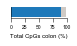

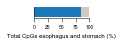

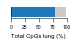

In [14]:
data = mutations_data

for ctype in ctypes_to_run: 

    fig = plt.figure(figsize=(1, 0.2))
    ax = plt.subplot2grid((1, 1), (0, 0))

    ax.set_xlabel(f'Total CpGs {tissue_d[ctype]} (%)', fontsize=6)
    
    methylated = 100 * data[ctype]['methylated'][1]
    unmethylated = 100 * data[ctype]['unmethylated'][1]

    plt.barh(y=1, left=0, width=methylated, align='center', alpha=1, color=colors_d['methylated'], height=0.8)
    plt.barh(y=1, left=methylated, width=unmethylated, align='center', alpha=1, color=colors_d['unmethylated'],  height=0.8)

    ax.set_yticklabels([], fontsize=5, rotation=0)
    ax.tick_params(axis='y', which='major', pad=2)
    ax.set_xlim(-1, 100)
    ax.set_xticks([0, 25, 50, 75, 100])
    ax.set_xticklabels([0, 25, 50, 75, 100], fontsize=5)

    ax.spines['left'].set(lw=0.5)
    ax.spines['bottom'].set(lw=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0)

    for extension in ['png']: 
        output = f'./fig_5C_{ctype}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel 5D

In [15]:
data = mutations_data

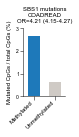

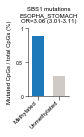

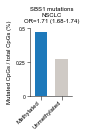

In [16]:
for ctype in ctypes_to_run: 
    
    odds_ratio, ci = mutations_or[ctype]
    
    fig = plt.figure(figsize=(0.75, 1.25))
    ax = plt.subplot2grid((1, 1), (0, 0))
    plt.title(f'SBS1 mutations\n{ctype}\nOR={round(odds_ratio, 2)} ({round(ci[0], 2)}-{round(ci[1], 2)})', fontsize=6)

    # Load data
    y_data = dict()
    y_data['methylated'] = 100 * data[ctype]['mut_mepos'][1]
    y_data['unmethylated'] = 100 * data[ctype]['mut_meneg'][1]
    c = [colors_d[t] for t in ['methylated', 'unmethylated']]

    ax.bar(range(2), [y_data['methylated'], y_data['unmethylated']], width=0.6, bottom=None, color=c, align='center', alpha=1, lw=0)
    
    if ctype == 'COADREAD': 
        ax.set_ylim(0, 2)
        ax.set_yticks([0, 1, 2, 3])
        ax.set_yticklabels([0, 1, 2, 3], fontsize=5)
    elif ctype == 'ESOPHA_STOMACH': 
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.5, 1])
        ax.set_yticklabels([0, 0.5, 1], fontsize=5)
    else: 
        ax.set_ylim(0, 0.5)
        ax.set_yticks([0, 0.25, 0.5])
        ax.set_yticklabels([0, 0.25, 0.5], fontsize=5)
        
    ax.set_ylabel('Mutated CpGs / total CpGs (%)', fontsize=6)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f"Methylated", f"Unmethylated"], fontsize=6, rotation=45, ha='right', va='top')
    ax.tick_params(axis='x', which='major', pad=0)
    ax.spines['left'].set(lw=0.5)
    ax.spines['bottom'].set(lw=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5, pad=1)
    
    for extension in ['png']: 
        output = f'./fig_5D_{ctype}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel 5E

In [17]:
data = hotspots_data

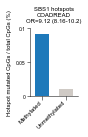

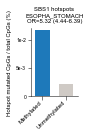

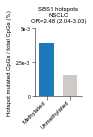

In [18]:
for ctype in ctypes_to_run: 
    
    odds_ratio, ci = hotspots_or[ctype]
    
    fig = plt.figure(figsize=(0.85, 1.25))
    ax = plt.subplot2grid((1, 1), (0, 0))
    plt.title(f'SBS1 hotspots\n{ctype}\nOR={round(odds_ratio, 2)} ({round(ci[0], 2)}-{round(ci[1], 2)})', fontsize=6)

    # Load data
    y_data = dict()
    y_data['methylated'] = 100 * data[ctype]['mut_mepos'][1]
    y_data['unmethylated'] = 100 * data[ctype]['mut_meneg'][1]
    c = [colors_d[t] for t in ['methylated', 'unmethylated']]

    ax.bar(range(2), [y_data['methylated'], y_data['unmethylated']], width=0.6, bottom=None, color=c, align='center', alpha=1, lw=0)
    
    if ctype == 'COADREAD': 
        ax.set_ylim(0, 0.1)
        ax.set_yticks([0, 0.05, 0.1])
        ax.set_yticklabels([0, 0.05, 0.1], fontsize=5)
    elif ctype == 'ESOPHA_STOMACH': 
        ax.set_ylim(0, 0.012)
        ax.set_yticks([0, 0.005, 0.01])
        ax.set_yticklabels(['0', '5e-3', '1e-2'], fontsize=5)
    else: 
        ax.set_ylim(0, 0.005)
        ax.set_yticks([0, 0.0025, 0.005])
        ax.set_yticklabels(['0', '2.5e-3', '5e-3'], fontsize=5)
    
    ax.set_ylabel('Hotspot mutated CpGs / total CpGs (%)', fontsize=6)
    ax.set_xlim(-0.5, 1.5)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f"Methylated", f"Unmethylated"], fontsize=6, rotation=45, ha='right', va='top')
    ax.tick_params(axis='x', which='major', pad=0)

    ax.spines['left'].set(lw=0.5)
    ax.spines['bottom'].set(lw=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5, pad=1)
    
    for extension in ['png']: 
        output = f'./fig_5E_{ctype}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)

## Panel 5F

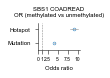

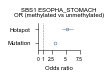

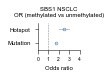

In [19]:
for ctype in ctypes_to_run: 

    fig = plt.figure(figsize=(0.75, 0.5))
    ax = plt.subplot2grid((1, 1), (0, 0))
    plt.title(f'SBS1 {ctype}\nOR (methylated vs unmethylated)', fontsize=6)
    ax.set_xlabel('Odds ratio', fontsize=6)

    # Mutations
    i = 0
    odds_ratio, ci = mutations_or[ctype]
    ax.scatter(odds_ratio, i, color='white', marker='o', s=8, lw=0.5, edgecolor='#1e79baff', zorder=1)
    ax.plot([ci[0], ci[1]], [i, i], ls='-', lw=0.5, c='grey', zorder=2)
    
    # Hotspots
    i = 1
    odds_ratio, ci = hotspots_or[ctype]
    ax.scatter(odds_ratio, i, color='white', marker='o', s=8, lw=0.5, edgecolor='#1e79baff', zorder=1)
    ax.plot([ci[0], ci[1]], [i, i], ls='-', lw=0.5, c='grey', zorder=2)

    ax.set_ylim(-0.5, 1.5)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Mutation', 'Hotspot'], fontsize=6)
    ax.axvline(x=1, color='grey', ls='--', lw=0.5)
    
    if ctype == 'COADREAD': 
        ax.set_xlim(0, 10.5)
        ax.set_xticks([0, 1, 2.5, 5, 7.5, 10])
        ax.set_xticklabels([0, 1, 2.5, 5, 7.5, 10], fontsize=5, rotation=0, ha='center')
        
    elif ctype == 'ESOPHA_STOMACH': 
        ax.set_xlim(0, 7.5)
        ax.set_xticks([0, 1, 2.5, 5, 7.5])
        ax.set_xticklabels([0, 1, 2.5, 5, 7.5], fontsize=5, rotation=0, ha='center')
    
    elif ctype == 'NSCLC': 
        ax.set_xlim(0, 4)
        ax.set_xticks([0, 1, 2, 3, 4])
        ax.set_xticklabels([0, 1, 2, 3, 4], fontsize=5, rotation=0, ha='center')

    ax.spines['left'].set(lw=0.5)
    ax.spines['bottom'].set(lw=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_tick_params(width=0.5)
    ax.yaxis.set_tick_params(width=0.5)
    
    for extension in ['png']: 
        output = f'./fig_5F_{ctype}.{extension}'
        plt.savefig(output, bbox_inches='tight', dpi=350)